# Data Handling and Fitting
## PyIU Advanced Python Workshop

Author: Robert Howard

Last modified: 4/17/2025

This notebook covers the basics of reading and writing data, as well as several methods for fitting simple models to data.

### Reading, Writing, and Fitting with Hubble's Law

We'll begin with an astronomical example of how to read in data, write data to a file, and fit a linear function. After that, we'll explore some other methods for fitting models to data in Python.

Hubble's law asserts that the recessional velocities of nearby galaxies (that is, how quickly they're moving away from us) are directly proportional to their distances from us. This relation is expressed mathematically as $$v=H_0d,$$ where $v$ is a galaxy's recessional velocity, $d$ is the galaxy's distance from us, and $H_0$ is the constant of proportionality, known as the [Hubble constant](https://news.uchicago.edu/explainer/hubble-constant-explained).

The file `cf3_data.tsv` contains distances, distance modulus errors (this is essentially a measure of how precisely we know each galaxy's distance), and recessional velocities of nearly 18,000 galaxies, obtained from the third data release of the [Cosmicflows](https://ui.adsabs.harvard.edu/abs/2016AJ....152...50T/abstract) survey. To use this data to practice reading, writing, and fitting, we'll proceed in four steps:
1) Read in the data using `np.loadtxt` and filter it.
2) Fit a linear function to the data using `np.polyfit`.
3) Plot both the data and the fit.
4) Save the data, along with some of our own, to a file using `np.savetxt`.

Note: `cf3_data.tsv` needs to be in the same directory as this notebook. If you're using Google Colab, you'll need to upload the file to your session storage. To do so, click the "Files" icon on the left side of the screen, then click the left-most icon in the panel that opens (which should say "Upload to session storage" when you hover over it), navigate to the file in your directory structure, and upload it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in data and store in arrays
# The optional arguments to np.loadtxt tell Python:
# - ("delimiter") how the entries in the file are separated,
# - ("skiprows") how many rows at the top of the file contain comments instead of data, and
# - ("unpack") that we want to split the columns of data into three separate 1D arrays, instead of one 2D array.
dist, dm_error, vel = np.loadtxt('cf3_data.tsv', delimiter = '\t', skiprows = 35, unpack = True)

# Select only nearby galaxies with precisely measured distances
distcut = 100 # Units of Mpc
errcut = 0.42 # Unitless
dist_cut = dist[(dist < distcut) & (dm_error < errcut)]
vel_cut = vel[(dist < distcut) & (dm_error < errcut)]

In [3]:
# Compute fit parameters and print our estimate of the Hubble constant
# np.polyfit takes in x-values, y-values, and the order of the polynomial to be fit
slope, intercept = np.polyfit(dist_cut, vel_cut, 1)
print(f'Estimate of Hubble constant: {round(slope, 2)} km/s/Mpc')

# Compute predicted velocity values based on fit parameters
vel_predict = slope*dist_cut + intercept

Estimate of Hubble constant: 72.63 km/s/Mpc


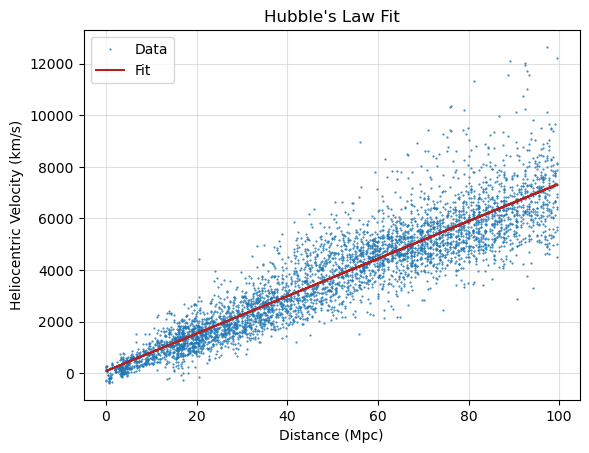

In [4]:
# Plot the data and the fit
fig, ax = plt.subplots()
ax.plot(dist_cut, vel_cut, marker = 'o', ls = '', markersize = 0.5, label = 'Data', zorder = 2.5)
ax.plot(dist_cut, vel_predict, color = 'firebrick', label = 'Fit', zorder = 3)
ax.set(xlabel = 'Distance (Mpc)', ylabel = 'Heliocentric Velocity (km/s)', title = 'Hubble\'s Law Fit')
ax.legend()
ax.grid(color = 'lightgray', alpha = 0.7)
# plt.savefig('hubble_law.png') # Saves the plot as a .png file, optional
plt.show()

It can be useful to have a record of the calculations we perform using our input data. In this example, we save the filtered distances, distance modulus errors, and recessional velocities to an output file, along with the predicted velocities we computed earlier and an "index" column to number the galaxies.

In [5]:
# Filter the distance modulus error the same way we filtered the distance and velocity
dm_error_cut = dm_error[(dist < distcut) & (dm_error < errcut)]

# Compute an index array to add to our output file
index = np.arange(len(dist_cut)) + 1

# Compile the data and write to a .txt file, using similar column formatting to the input file
save_data = np.vstack((index, dist_cut, dm_error_cut, vel_cut, vel_predict)).T
fmt_string = '%4d  %5.2f  %4.2f  %5d  %5d'
header_string = 'index dist_cut dm_error_cut vel_cut vel_predict'
np.savetxt('cf3_data_with_predictions.txt', save_data, fmt = fmt_string, header = header_string)

### Polynomial Fitting with `np.polyfit`

`np.polyfit` is the simplest way to fit data in Python, but as the name suggests, it only works with polynomials. Since we've already used it to fit a straight line, we'll show it in action with a higher-order polynomial here.

In its simplest use case, `np.polyfit` takes three arguments: your $x$ values, your $y$ values, and the degree of the polynomial you want to fit. Using [least-squares regression](https://en.wikipedia.org/wiki/Least_squares), it then returns a tuple containing the fit parameters defining the best-fit polynomial of the specified degree. Least-squares regression is an algorithm that determines the fit parameters that minimize the sum of the squared distances between the data points and the best-fit curve &mdash; the distances are squared so that points below and above the line contribute in the same way. `np.polyfit` has many other features as well, all of which you can learn more about on its [documentation page](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html).

As a reminder for this example, a cubic polynomial has the form $$f(x)=ax^3+bx^2+cx+d.$$

Optimal a: -0.723
Optimal b: 4.834
Optimal c: -8.79
Optimal d: 4.947


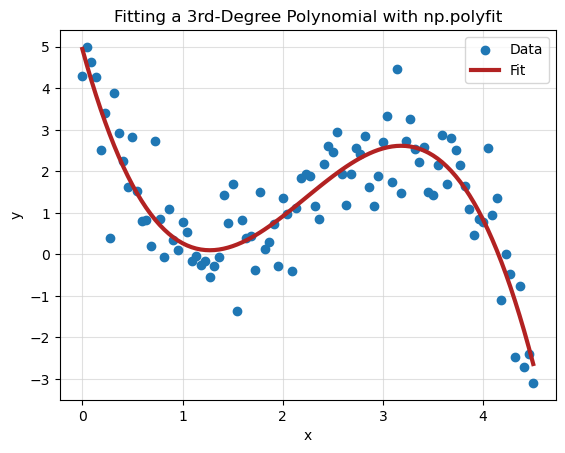

In [6]:
# Define a cubic function
def cubic(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

# Specify fit parameters and x range, then compute y values
a, b, c, d = -0.75, 5, -9, 5
x = np.linspace(0, 4.5, 100)
y = cubic(x, a, b, c, d)

# Add noise from a Gaussian (normal) distribution with mean 0 and standard deviation 0.8
# This is a way to make our artificial data in this example look more like real data. We're
# adding a random small number (positive or negative) to each y-value we computed above
# to simulate the scatter one would see in real data
y += np.random.normal(0, 0.8, len(x))

# Perform fit to find optimal fit parameters, then print results
# In this example, our fit parameters should be nearly identical to those we started with,
# but in real-world settings we won't always know what they're supposed to be
p = np.polyfit(x, y, 3)
y_fit = cubic(x, *p)
for let, val in zip(('a', 'b', 'c', 'd'), p):
    print(f'Optimal {let}: {round(val, 3)}')

# Plot results
fig, ax = plt.subplots()
ax.scatter(x, y, color = 'C0', label = 'Data', zorder = 2.5)
ax.plot(x, y_fit, color = 'firebrick', lw = 3, label = 'Fit', zorder = 3)
ax.set(xlabel = 'x', ylabel = 'y', title = 'Fitting a 3rd-Degree Polynomial with np.polyfit')
ax.grid(color = 'lightgray', alpha = 0.7)
ax.legend()
plt.show()

### General Fitting with `scipy.optimize.curve_fit`

`scipy.optimize.curve_fit` is much more powerful than `np.polyfit`, because it can fit a function of *any form*. Instead of specifying the degree of the polynomial you want to be fit, you give `curve_fit` a function definition with as many free parameters as you want, and `curve_fit` will account for all of them, again using least-squares regression.

In its simplest use case, `curve_fit`takes three arguments: the function you want to fit to, your x values, and your y values. It then returns a tuple containing the optimal fit parameters (`popt`) and a covariance matrix (`pcov`). The covariance matrix can be used to estimate the uncertainties on the fit parameters.

As with `np.polyfit`, `curve_fit` can do all kinds of other things, all of which are described in detail on its [documentation page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

In [7]:
from scipy.optimize import curve_fit

The function we'll fit in this first example has the general form $$f(x)=\frac{a}{x+b}.$$

Optimal a: 2.119 +/- 0.135
Optimal b: -1.954 +/- 0.055


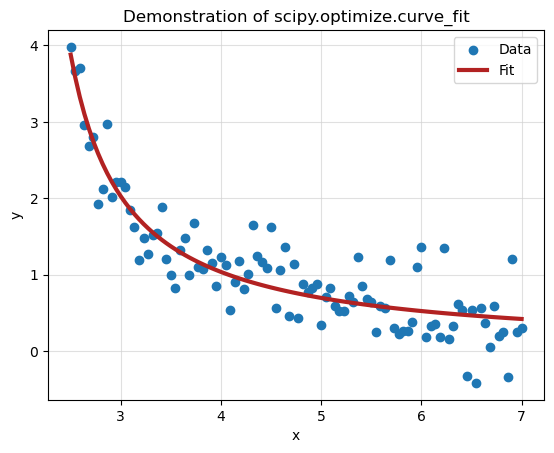

In [8]:
# Define a simple function to test
# The order of the arguments here is important: the independent variable must come first, followed by
# all the fit parameters as separate arguments
def my_function(x, a, b):
    return a/(x + b)

# Specify fit parameters and x range, then compute y values
params = (2, -2)
x = np.linspace(2.5, 7, 100)
y = my_function(x, *params)

# Add noise 
y += np.random.normal(0, 0.4, len(x))

# Perform fit
popt, pcov = curve_fit(my_function, x, y)

# Compute uncertainties on fit parameters from covariance matrix
# Because we have two fit parameters in this example, the covariance matrix is a 2x2 matrix. The
# uncertainties on our fit parameters are the square roots of the elements on the main diagonal
# of this matrix
perr = np.sqrt(np.diag(pcov))

# Compute y values of the fit line and print results
y_fit = my_function(x, *popt)
for let, val, err in zip(('a', 'b'), popt, perr):
    print(f'Optimal {let}: {round(val, 3)} +/- {round(err, 3)}')

# Plot results
fig, ax = plt.subplots()
ax.scatter(x, y, color = 'C0', label = 'Data', zorder = 2.5)
ax.plot(x, y_fit, color = 'firebrick', lw = 3, label = 'Fit', zorder = 3)
ax.set(xlabel = 'x', ylabel = 'y', title = 'Demonstration of scipy.optimize.curve_fit')
ax.grid(color = 'lightgray', alpha = 0.7)
ax.legend()
plt.show()

That wasn't so bad! Here's a slightly more complicated example, where it helps to include initial guesses for the values of our fit parameters. Sometimes including initial guesses can help `curve_fit` successfully fit a dataset when it would otherwise fail. The function we'll use in this example is a modified sinusoid with exponentially decaying amplitude, which has the general form $$f(x)=ae^{bx}\sin(cx+d)+ex+f.$$ Note: the fit parameter $e$ here is different from the mathematical constant $e\approx2.718$!

Optimal a: 1.971 +/- 0.118
Optimal b: -0.618 +/- 0.053
Optimal c: 4.899 +/- 0.05
Optimal d: -0.95 +/- 0.053
Optimal e: 0.249 +/- 0.021
Optimal f: 2.908 +/- 0.05


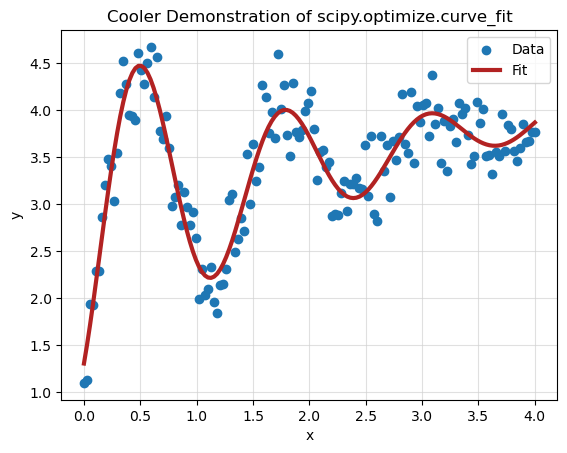

In [9]:
# Define a cooler-looking function
def my_cooler_function(x, a, b, c, d, e, f):
    return a*np.exp(b*x)*np.sin(c*x + d) + e*x + f

# Specify fit parameters and x range, then compute y values
params = (2, -0.6, 5, -1, 0.2, 3)
x = np.linspace(0, 4, 150)
y = my_cooler_function(x, *params)

# Add noise
y += np.random.normal(0, 0.3, len(x))

# Perform fit, including initial guesses, because this particular fit sometimes fails without them
popt, pcov = curve_fit(my_cooler_function, x, y, p0 = (1, -1, 4, 0, 0.5, 2))

# Compute uncertainties on fit parameters from covariance matrix
perr = np.sqrt(np.diag(pcov))

# Compute y values of the fit line and print results
y_fit = my_cooler_function(x, *popt)
for let, val, err in zip(('a', 'b', 'c', 'd', 'e', 'f'), popt, perr):
    print(f'Optimal {let}: {round(val, 3)} +/- {round(err, 3)}')

# Plot results
fig, ax = plt.subplots()
ax.scatter(x, y, color = 'C0', label = 'Data', zorder = 2.5)
ax.plot(x, y_fit, color = 'firebrick', lw = 3, label = 'Fit', zorder = 3)
ax.set(xlabel = 'x', ylabel = 'y', title = 'Cooler Demonstration of scipy.optimize.curve_fit')
ax.grid(color = 'lightgray', alpha = 0.7)
ax.legend()
plt.show()

### Orthogonal Distance Regression with `scipy.odr`

Orthogonal distance regression (ODR) isn't inherently more advanced or intricate than least-squares regression with `curve_fit`. It uses a different method to optimize the fit parameters, so sometimes it will succeed where `curve_fit` fails. Instead of minimizing the vertical distances between the points and the fit, ODR minimizes the total distance between the points and the fit, accounting for horizontal offsets as well. (See this [Wikipedia article](https://en.wikipedia.org/wiki/Total_least_squares#Background) for a nice illustration, but don't worry about all the matrix math.)

ODR also allows you to account for errors in both the independent and dependent variables (x and y), while `curve_fit` only allows for errors in the dependent variable (y). We won't cover this here, but see the [documentation page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.odr.ODR.html) for more details.

Here's a very simple example illustrating the mechanics of `scipy.odr`.

In [10]:
from scipy import odr

Optimal slope: 3.978 +/- 0.152
Optimal y-int: -7.94 +/- 0.268


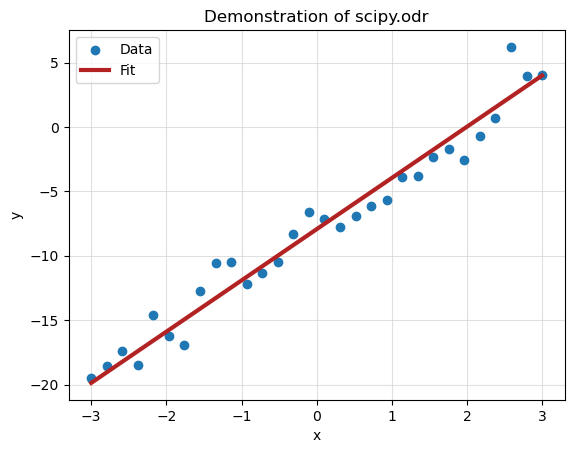

In [11]:
# Define a simple linear function to test
# The order of the arguments is important here as well, but different than with curve_fit: the independent variable
# comes second, preceded by a tuple (or list, numpy array, etc.) containing the fit parameters
def fit_function(p, x):
    return p[0]*x + p[1]

# Specify fit parameters and x range, then compute y values and add noise
p = (4, -8)
x = np.linspace(-3, 3, 30)
y = fit_function(p, x)
y += np.random.normal(0, 1.5, len(x))

# Here we start using the odr module. First, we define a "Model" object based on the function we want to fit
model = odr.Model(fit_function)

# Next, we package our data points inside a special "Data" object
# This would look a little different if our points had error bars; we would instead use odr.RealData
data = odr.Data(x, y)

# We then create an "ODR" object, which will perform the fits later. We must give it initial guesses for the fit
# parameters. Because we're fitting such a simple function, we can generate those initial guesses with np.polyfit
fitter = odr.ODR(data, model, beta0 = np.polyfit(x, y, 1))

# Perform fit and retrieve fit parameters and errors
output = fitter.run()
popt, perr = output.beta, output.sd_beta

# Compute y values of the fit line and print results
y_fit = fit_function(popt, x)
for param, val, err in zip(('slope', 'y-int'), popt, perr):
    print(f'Optimal {param}: {round(val, 3)} +/- {round(err, 3)}')

# Plot results
fig, ax = plt.subplots()
ax.scatter(x, y, color = 'C0', label = 'Data', zorder = 2.5)
ax.plot(x, y_fit, color = 'firebrick', lw = 3, label = 'Fit', zorder = 3)
ax.set(xlabel = 'x', ylabel = 'y', title = 'Demonstration of scipy.odr')
ax.grid(color = 'lightgray', alpha = 0.7)
ax.legend()
plt.show()

### Further Explorations in Fitting

- [Symbolic regression](https://en.wikipedia.org/wiki/Symbolic_regression) with [gplearn](https://gplearn.readthedocs.io/en/stable/) or [PySR](https://github.com/MilesCranmer/PySR). This technique doesn't require you to know the function you want to fit to your data. Instead, the algorithm will produce its best guess at the functional form that best approximates the data!
- Interpolation with cubic splines using [scipy.interpolate.CubicSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html). Interpolation involves finding a function that passes directly through each input data point instead of simply passing nearby. For this reason, interpolation is better suited for cases when you know that every data point should lie exactly on the function, or in other words, when there's no noise in the data.